---
title: "The impact of COVID-19 restriction on start-up grant application"
author: "Babak Fi Foo"
toc: true
number-sections: true
execute:
  cache: true
---

In [1]:
import sys
sys.path.append("../src/")
sys.path.append("../")

import warnings

from datetime import datetime as dt

import apiConfig
import statTools
# REMOVE importing this module is only for data processing and testing.
# from dataCleaners import *

import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

from arch.unitroot.unitroot import DFGLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


from matplotlib.collections import PolyCollection

warnings.filterwarnings("ignore")
plt.rcParams["font.family"] = "Roboto"

startupGrants = apiConfig.startupGrants
startupGrants.load()

grant_data = startupGrants.cleaned_data
labels:dict = startupGrants.labels

Loading Startup Grant Applications data ...
The data file exists
Startup Grant Applications Data loaded.



# Testing for unit root

Before performing any time-series analysis, we need to investigate the properties of the data.
From now on, we refer to the time-series data as series. The duration that we are interested is quite close to the COVID time where there is an increase in the count of applications for the startup grants. 

We specify the COVID restriction period from April 2020 until February 2022.

Investigating this period has the potential to wrongly identify the series as a trend stationary. Therefore, the whole duration of the data is used for this test statistics to avoid any potential bias.

In [2]:
# FIXED PARAMETERS:
COVID_start = dt.strptime("2020-04-01", "%Y-%m-%d")
COVID_end = dt.strptime("2022-02-01", "%Y-%m-%d")

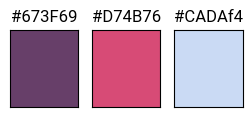

In [3]:
color_pallet = {
    "c1":"#673F69",
    "c2":"#D74B76",
    "shade":"#CADAf4"
}
fig, axes = plt.subplots(1,len(color_pallet.keys()), figsize=(len(color_pallet.keys()),1))

[ax.get_xaxis().set_visible(False) for ax in axes]
[ax.get_yaxis().set_visible(False) for ax in axes]
for i,k in enumerate(color_pallet.keys()):
    axes[i].set_facecolor(color_pallet[k])
    axes[i].set_title(color_pallet[k])

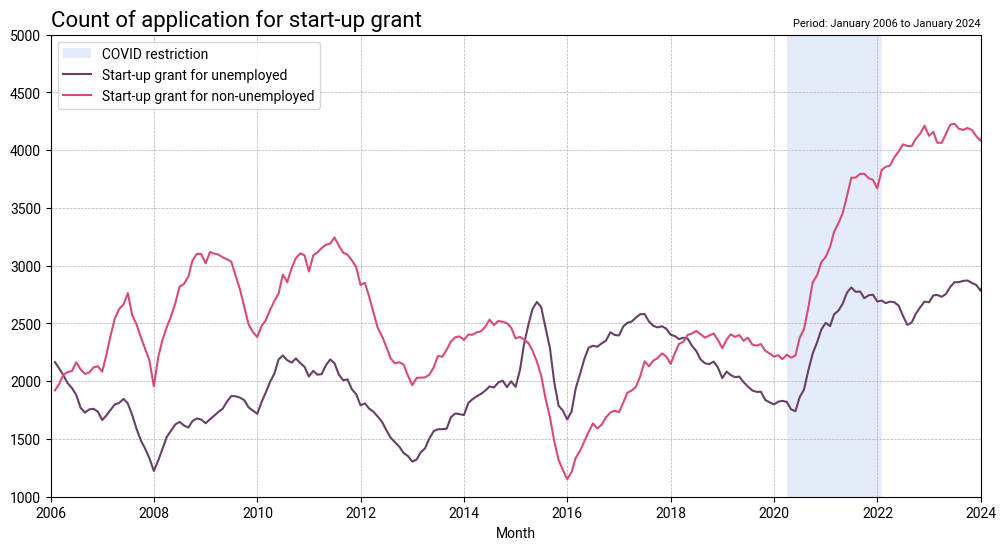

In [4]:
fig = plt.figure(figsize=(12, 6))
plt.grid(True, which="both", ls="--", lw=0.5)

plt.xlim(dt.strptime("2006-01-01", "%Y-%m-%d"), dt.strptime("2024-01-01", "%Y-%m-%d"))
plt.ylim(1000, 5000)
ax = plt.gca()

plt.fill_between(
    x=[COVID_start, COVID_end],
    y1=0,
    y2=8000,
    facecolor=color_pallet["shade"],
    alpha=0.5,
    label="COVID restriction",
)
sns.lineplot(
    data=grant_data.loc[:, ["grantUnemp", "grantEmp"]].rename(columns=labels),
    palette=[color_pallet["c1"], color_pallet["c2"]],
    dashes=False,
    ax=ax,
)
legend = ax.legend(loc="upper left")
legend.set_title("")

plt.title("Count of application for start-up grant", fontsize=16, loc="left")
plt.title("Period: January 2006 to January 2024", fontsize=8, loc="right")
plt.show()

The visual inspection of the plot indicates that the series are not stationary. However, the type of non-stationarity requires further investigations.
The DF-GLS test for unit-root shows that both series are affected by unit-root at their 7th lag, and cannot reject the existance of the unit-root. Hence proper alteration should be applied to make the series stationary. 

In [5]:
col1 = "grantUnemp"
col2 = "grantEmp"
test_df = grant_data.loc[:, [col1,col2]].rename(columns=labels)
unitroot_test = statTools.DFGLSTest(data=test_df)
unitroot_test.summary()

                                  Test Statistic P-value Lags
variable                                                     
Start-up grant for unemployed             -2.015   0.044    1
Start-up grant for non-unemployed          0.441   0.824   13

Trend: Constant
Critical Values: -2.66 (1%), -2.04 (5%), -1.72 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.



First differencing the series resulted in a stationary series. This means that the unit-root is not cause by trend, nor drift. Hence the plausable data generating process is:

$$
	y_{t} = \alpha_0 + \alpha_1 y_{t-1} + \varepsilon_{t}
$$


where $y_{t}$ is the series, $\alpha_0$ and $\alpha_1$ are the unknown coefficients, and $\varepsilon_{t}$ is a white-noise disturbance. The coefficient $\alpha_1$ is assumed to be equals to $1$ because of the unit-root properties of the series. First differencing the series should make the series stationary:

$$ y_{t} - y_{t-1} = \Delta y_t=\alpha_0 + y_{t-1} - y_{t-1} + \varepsilon_{t} =  \alpha_0 + \varepsilon_{t} $$


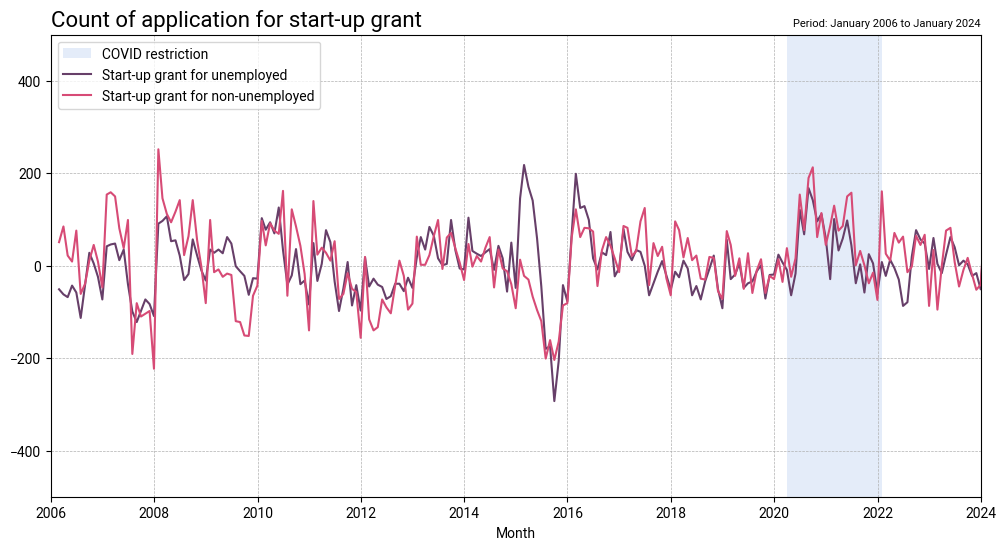

In [6]:
plot_df = (
    grant_data.loc[:, ["grantUnemp", "grantEmp"]].diff().rename(columns=labels).copy()
)
fig = plt.figure(figsize=(12, 6))
plt.grid(True, which="both", ls="--", lw=0.5)
plt.xlim(dt.strptime("2006-01-01", "%Y-%m-%d"), dt.strptime("2024-01-01", "%Y-%m-%d"))
plt.ylim(-500, 500)
ax = plt.gca()

plt.fill_between(
    x=[COVID_start, COVID_end],
    y1=-1000,
    y2=1000,
    facecolor=color_pallet["shade"],
    alpha=0.5,
    label="COVID restriction",
)
sns.lineplot(
    data=plot_df,
    palette=[color_pallet["c1"], color_pallet["c2"]],
    dashes=False,
    ax=ax,
)
legend = ax.legend(loc="upper left")
legend.set_title("")

plt.title("Count of application for start-up grant", fontsize=16, loc="left")
plt.title("Period: January 2006 to January 2024", fontsize=8, loc="right")
plt.show()
del plot_df

In [7]:
col1 = "grantUnemp"
col2 = "grantEmp"
diff_test_df = grant_data[[col1,col2]].diff().dropna().rename(columns=labels)
unitroot_test = statTools.DFGLSTest(data=diff_test_df)
unitroot_test.summary()
del diff_test_df

                                  Test Statistic P-value Lags
variable                                                     
Start-up grant for unemployed             -5.802   0.000    0
Start-up grant for non-unemployed         -3.363   0.001   12

Trend: Constant
Critical Values: -2.66 (1%), -2.04 (5%), -1.72 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.



As tables show, both series are stationary after first-differencing.

# Time-Series properties of the data:

In [8]:
# discovered on 2024-03-29 10:49:47
def apply_TSplot_theme(axes):
    for ax in axes:
        ax.grid(True, which="both", ls="--", lw=0.5)
        ax.set_ylim(-1.2, 1.2)
        ax.set_xticks(range(0,26,2))
        for line in ax.lines:
            line.set_color("none")
            line.set_markerfacecolor(color_pallet["c1"])
            line.set_markersize(4)
            line.set_markeredgecolor("white")
        for item in ax.collections:
            if type(item)==PolyCollection:
                item.set_facecolor(color_pallet["shade"])
            else:
                item.set_color(color_pallet["c2"])

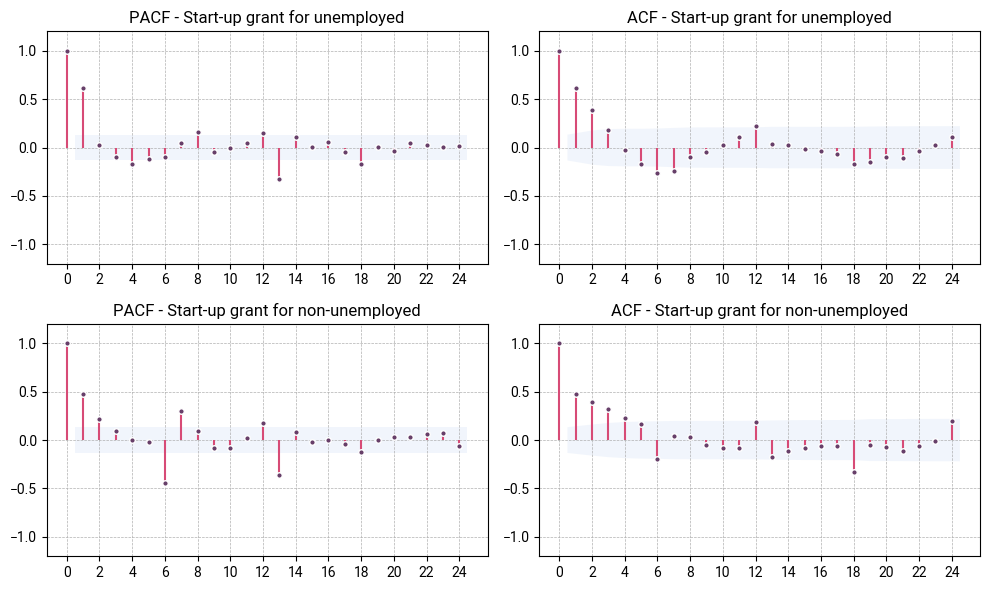

In [9]:
fig= plt.figure(figsize=(10,6))
LAGS = 24

for i, col in enumerate(["grantUnemp", "grantEmp"]):
    params = dict(
        x=grant_data[col].diff().dropna(),
        lags=LAGS,
        alpha=0.05,
    )
    
    plot_pacf(
        title="PACF - {n}".format(n=labels[col]),
        ax=fig.add_subplot(2,2,1 + i*2),
        **params,
    )
    
    plot_acf(
        title="ACF - {n}".format(n=labels[col]),
        ax=fig.add_subplot(2,2,2 + i*2),
        **params,
    )


apply_TSplot_theme(fig.get_axes())
        
fig.tight_layout()
plt.show()

The PACF plot shows autocorrelation at lages 1,6, and 7. Therefore they are included in the linear model. Further, two constants are added for dates 2020-05-01, 2021-12-01, where they have value 0 prior to the date, and 1 thereafter. 

These two dates were derived from the data itself, eventhough COVID restrictions were lifted two months after. 

# Univariate Time-Series Analysis:


In [108]:
def plot_Q_stats(arr,ax,nlags=24):
    Q_stat = acf(arr, qstat=True, nlags=nlags)[2]
    ax.plot(np.arange(1,25),Q_stat, linestyle='--', marker='o',color = color_pallet["c2"]) 
    ax.grid(True, which="both", ls="--", lw=0.5)
    ax.set_ylim(0, 1.2)
    ax.set_xticks(range(0,26,2))
    ax.lines[0].set_markerfacecolor(color_pallet["c1"])
    ax.lines[0].set_markersize(6)
    ax.lines[0].set_markeredgecolor("white")

In [103]:
def plot_CDF_vs_normal(arr, ax):
    mu = np.mean(arr)
    sigma = np.std(arr)
    normal_sample = np.random.normal(mu, sigma, len(arr))
    sns.kdeplot(
        normal_sample,
        cumulative=True,
        label="Normal CDF",
        ax=ax,
        color=color_pallet["c1"],
    )
    sns.kdeplot(
        arr, cumulative=True, label="Residual CDF", ax=ax, color=color_pallet["c2"]
    )
    ax.legend()
    ax.grid(True, which="both", ls="--", lw=0.5)

## Start-up grant for unemployed

In [104]:
col = "grantUnemp"
model_df = grant_data.copy()
model_df.loc[:, "COVID start"] = (model_df.index >= "2020-04-01").astype(int)
model_df.loc[:, "COVID func end"] = (model_df.index >= "2021-07-01").astype(int)
model_df.loc[:, "COVID end"] = (model_df.index >= "2022-02-01").astype(int)
model_df[(col + " diff")] = model_df[col].diff()
model_df = model_df.dropna()

model = SARIMAX(
    model_df[col + " diff"],
    exog=model_df[["COVID start","COVID func end", "COVID end"]],
    order=([1,4,8], 0,0),
    seasonal_order=(0, 0, 1, 12),
).fit(disp = False)
print(model.summary())

                                          SARIMAX Results                                           
Dep. Variable:                              grantUnemp diff   No. Observations:                  187
Model:             SARIMAX([1, 4, 8], 0, 0)x(0, 0, [1], 12)   Log Likelihood                -993.667
Date:                                      Fri, 29 Mar 2024   AIC                           2003.334
Time:                                              14:29:52   BIC                           2029.183
Sample:                                                   0   HQIC                          2013.808
                                                      - 187                                         
Covariance Type:                                        opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
COVID start       65.9779 

The regression results shows a clear significance for both COVID start and COVID end. The residuals do not show any autoregressive behaviour, and therefore, the model is reliable. 

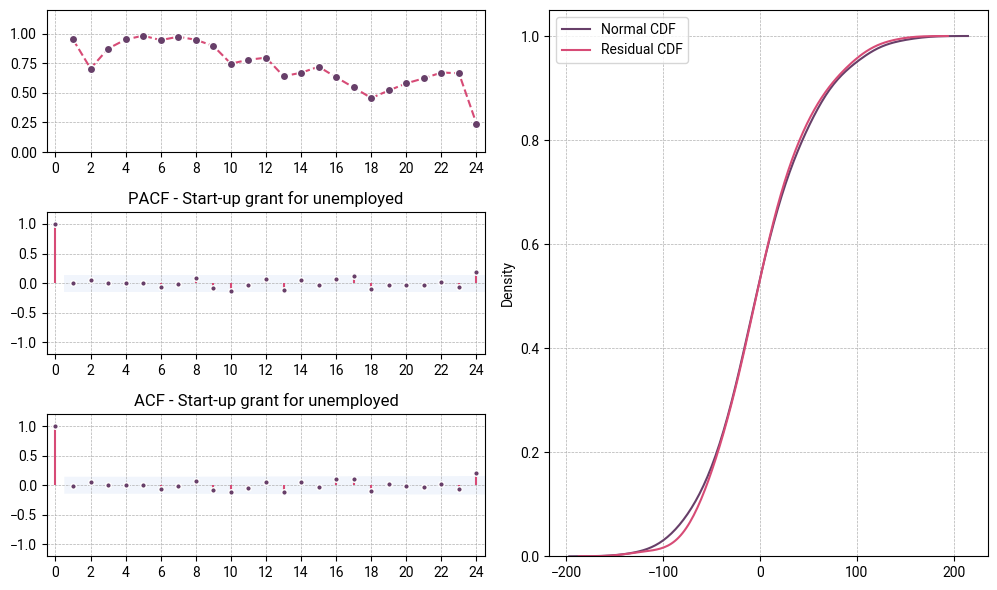

In [109]:
fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(1,2,2)

plot_CDF_vs_normal(model.resid.values, ax1)

params = dict(
    x=model.resid,
    lags=LAGS,
    alpha=0.05,
)
ax2 = fig.add_subplot(3,2,1)
plot_Q_stats(model.resid.values, ax2)

ax3 = fig.add_subplot(3,2,3)
plot_pacf(**params, title="PACF - {n}".format(n=labels[col]), ax=ax3)

ax4 = fig.add_subplot(3,2,5)
plot_acf(**params, title="ACF - {n}".format(n=labels[col]), ax=ax4)

apply_TSplot_theme([ax3, ax4])
for ax in [ax2,ax3,ax4]:
    ax.set_xlim(-0.5,24.5)
plt.tight_layout()
plt.show()

In [110]:
col = "grantEmp"
model_df = grant_data.copy()
model_df.loc[:, "COVID start"] = (model_df.index >= "2020-04-01").astype(int)
model_df.loc[:, "COVID func end"] = (model_df.index >= "2021-07-01").astype(int)
model_df.loc[:, "COVID end"] = (model_df.index >= "2022-02-01").astype(int)
model_df[(col + " diff")] = model_df[col].diff()
model_df = model_df.dropna()

model = SARIMAX(
    model_df[col + " diff"],
    exog=model_df[["COVID start", "COVID end","COVID func end"]],
    order=([1,6,7,13], 0,0),
    seasonal_order=(0, 0, 1, 12),
).fit(disp = False)
print(model.summary())

                                            SARIMAX Results                                             
Dep. Variable:                                    grantEmp diff   No. Observations:                  187
Model:             SARIMAX([1, 6, 7, 13], 0, 0)x(0, 0, [1], 12)   Log Likelihood               -1031.921
Date:                                          Fri, 29 Mar 2024   AIC                           2081.842
Time:                                                  14:30:57   BIC                           2110.922
Sample:                                                       0   HQIC                          2093.625
                                                          - 187                                         
Covariance Type:                                            opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

The result of ARMA model for the non-employed series again, affirms the changes in the levels of application attempts by population. 

The ACF and PACF plots of model residuals do not show any autoregressive behaviour. Therefore the model is fitting properly.

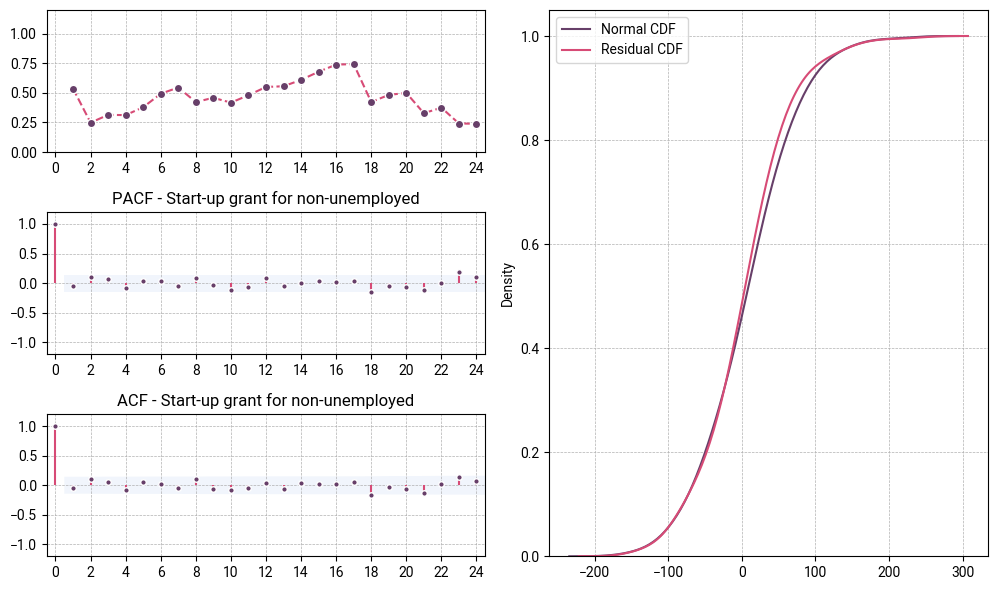

In [111]:
fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(1,2,2)

plot_CDF_vs_normal(model.resid.values, ax1)

params = dict(
    x=model.resid,
    lags=LAGS,
    alpha=0.05,
)
ax2 = fig.add_subplot(3,2,1)
plot_Q_stats(model.resid.values, ax2)

ax3 = fig.add_subplot(3,2,3)
plot_pacf(**params, title="PACF - {n}".format(n=labels[col]), ax=ax3)

ax4 = fig.add_subplot(3,2,5)
plot_acf(**params, title="ACF - {n}".format(n=labels[col]), ax=ax4)

apply_TSplot_theme([ax3, ax4])
for ax in [ax2,ax3,ax4]:
    ax.set_xlim(-0.5,24.5)
plt.tight_layout()
plt.show()